# 3A. Data Modeling: Airbnb Listings
<hr>

## Implement Baselines

To fit our baseline model we will use OLS (Ordinary Least Squares Regression). We will split our dataset into a train and test (65 / 35) and run 10 Linear Regression simulations to calculate the Train and Test Score. 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import sys
sys.path.append('/content/drive/My Drive/Masters Project/datasets/clean_datasets/')

In [3]:
!ls '/content/drive/My Drive/Masters Project/datasets/clean_datasets/'

calendar_clean.csv  listings_neighborhood_clean.csv
daily_price.csv     neighborhood_clustered_clean.csv
listings_clean.csv  seasonality_tomodel.csv


In [0]:
!pip install -q scikit-learn

In [0]:
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
from sklearn import linear_model
import sklearn.metrics as metrics
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import pylab
import scipy.stats as stats
%matplotlib inline

In [0]:
# helper function for plotting residual plots
def plot_residual(ax1, ax2, ax3, y_pred, y_real, line_label, title):
    ax1.scatter(y_pred, 
                y_real, 
                color='blue',
                alpha=0.6,
                label=line_label)
    ax1.set_xlabel('Predicted Y') 
    ax1.set_ylabel('Real Y')
    ax1.legend(loc='best')
    ax1.set_title(title)

    ax2.scatter(y_pred,
                y_real - y_pred, 
                color='green',
                marker='x',
                alpha=0.6,
                label='Residual')
    ax2.set_xlabel('Predicted Y')
    ax2.set_ylabel('Residual')
    
    ax2.axhline(y=0, color='black', linewidth=2.0, alpha=0.7, label='y=0')

    ax2.legend(loc='best')
    ax2.set_title('Residual Plot')
    
    ax3.hist(y_real - y_pred, bins=30, color='green', alpha=0.7)
    ax3.set_title('Histogram of residual values')
    
    return ax1, ax2, ax3

In [0]:
class model:
    
    def __init__(self, model):
        self.model = model
        self.x_train = None
        self.y_train = None
        self.x_test = None
        self.y_test = None
        self.y_pred_train = None
        self.y_pred_test = None
        self.train_score = None
        self.test_score = None
        self.train_score_log = None
        self.test_score_log = None
    
    def data_split(self, x, y, test_size):
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(x, y, test_size=test_size)
    
    def score_reg(self):
        return self.train_score, self.test_score
    
    def score_log(self):
        self.train_score_log = metrics.r2_score(np.exp(self.y_train), np.exp(self.y_pred_train))
        self.test_score_log = metrics.r2_score(np.exp(self.y_test), np.exp(self.y_pred_test))
        return self.train_score_log, self.test_score_log
    
    def data_frame_convert(self):
        df_train = pd.DataFrame({'y_pred': self.y_pred_train, 'y_real': self.y_train})
        df_test = pd.DataFrame({'y_pred_test': self.y_pred_test, 'y_real_test': self.y_test})
        return self.train_score, self.test_score, df_train, df_test

    def data_frame_convert_log(self):
        df_train = pd.DataFrame({'y_pred': np.exp(self.y_pred_train), 'y_real': np.exp(self.y_train)})
        df_test = pd.DataFrame({'y_pred_test': np.exp(self.y_pred_test), 'y_real_test': np.exp(self.y_test)})
        return self.train_score_log, self.test_score_log, df_train, df_test
    
    def fit_model(self, x, y, test_size):
        self.data_split(x, y, test_size)
        self.model = self.model.fit(self.x_train, self.y_train)
        self.train_score = self.model.score(self.x_train, self.y_train)
        self.test_score = self.model.score(self.x_test, self.y_test)
        self.y_pred_train = self.model.predict(self.x_train)
        self.y_pred_test = self.model.predict(self.x_test)
    
def model_iterations(n, x, y, model_arg, log_bool=False):
    training_scores = [None]*n
    testing_scores = [None]*n

    for i in range(n):
        new_model = model(model_arg)
        new_model.fit_model(x, y, 0.3)
        training_scores[i], testing_scores[i] = new_model.score_reg() if not log_bool else new_model.score_log()

    print ('Mean Train Score:', np.mean(training_scores))
    print ('Mean Test Score:', np.mean(testing_scores))
    return new_model

In [18]:
data = pd.read_csv('/content/drive/My Drive/Masters Project/datasets/clean_datasets/listings_clean.csv')
data.head()

,id,host_id,host_listings_count,accommodates,bathrooms,bedrooms,beds,minimum_nights,availability_30,number_of_reviews,94014,94015,94080,94102,94103,94104,94105,94107,94108,94109,94110,94111,94112,94113,94114,94115,94116,94117,94118,94121,94122,94123,94124,94127,94129,94131,94132,94133,94134,94158,...,Bungalow,Cabin,Camper/RV,Condominium,Cottage,Dome house,Earth house,Guest suite,Guesthouse,Hostel,Hotel,House,Loft,Other,Resort,Serviced apartment,Timeshare,Tiny house,Townhouse,Villa,Entire home/apt,Private room,Shared room,Airbed,Couch,Futon,Pull-out Sofa,Real Bed,20-29,30-39,40-49,50-59,60-69,70-79,80-84,85-89,90-94,95-100,price,price_log
0,958,1169,-0.153604,-0.163713,-0.442214,-0.612015,0.115414,-0.013506,-0.702780,1.700370,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,170.0,5.135798
1,3850,4921,-0.143965,-0.658095,-0.442214,-0.612015,-0.706403,-0.013506,1.123778,0.940286,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,99.0,4.595120
2,5858,8904,-0.143965,0.825050,-0.442214,0.563619,0.937230,-0.013485,-0.816940,0.638665,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,235.0,5.459586
3,7918,21994,-0.066847,-0.658095,2.858608,-0.612015,-0.706403,-0.013483,-0.246140,-0.495429,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,65.0,4.174387
4,8142,21994,-0.066847,-0.658095,2.858608,-0.612015,-0.706403,-0.013483,2.607857,-0.604013,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,65.0,4.174387


In [0]:
# split into x and y (note that we do not include id and host_id as predictors)
x = data.iloc[:, 2:-2]
y = data.iloc[:, -2]
y_log = data.iloc[:, -1]

## Linear Regression Model
### Linear Regression with Non Transformed Response

In [0]:
x = x.fillna(method='ffill')

In [21]:
Lin_Reg_Model = model_iterations(1, x, y, Lin_Reg(fit_intercept=True))

Mean Train Score: 0.22921014361271108
Mean Test Score: -7.243447942271835e+20


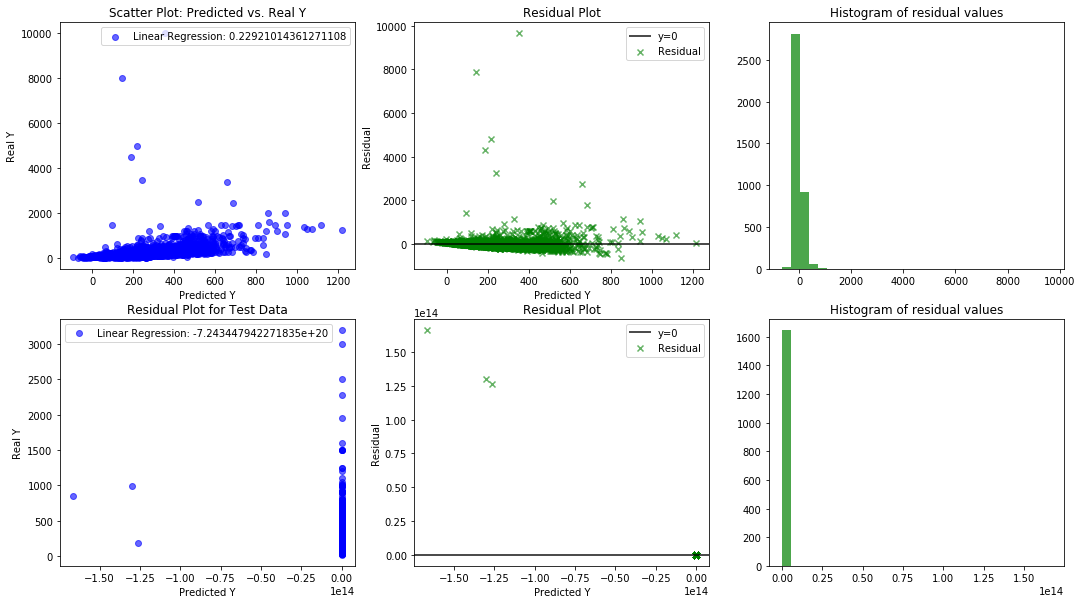

In [22]:
# plot the residuals of a linear regression model
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

data_vals = Lin_Reg_Model.data_frame_convert()
plot_residual(axes[0][0], axes[0][1], axes[0][2], data_vals[2]['y_pred'], data_vals[2]['y_real'], 'Linear Regression: {}'.format(data_vals[0]), 'Scatter Plot: Predicted vs. Real Y')
plot_residual(axes[1][0], axes[1][1], axes[1][2], data_vals[3]['y_pred_test'], data_vals[3]['y_real_test'], 'Linear Regression: {}'.format(data_vals[1]), 'Residual Plot for Test Data')
plt.show()

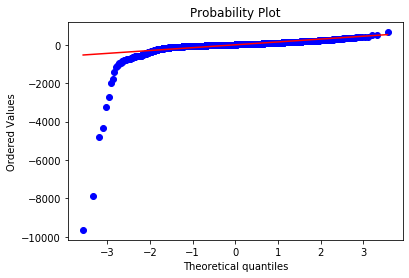

In [23]:
# qq plot for the train residuals
stats.probplot(data_vals[2]['y_pred'] - data_vals[2]['y_real'], dist="norm", plot=pylab)
pylab.show()

### Linear Regression with Log-Transformed Response

In [0]:
x = x.fillna(method='ffill')

In [26]:
Lin_Reg_Model_Log = model_iterations(1, x, y_log, Lin_Reg(fit_intercept=True), True)

Mean Train Score: 0.28295939678502335
Mean Test Score: 0.20950213131220896


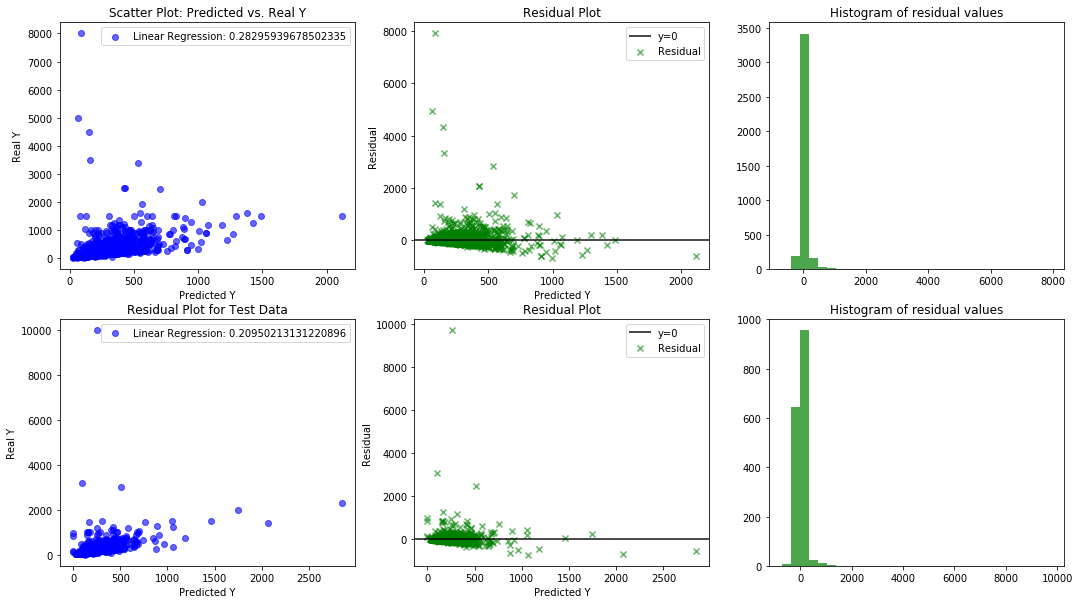

In [27]:
# plot the residuals of a linear regression model
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

data_vals = Lin_Reg_Model_Log.data_frame_convert_log()
plot_residual(axes[0][0], axes[0][1], axes[0][2], data_vals[2]['y_pred'], data_vals[2]['y_real'], 'Linear Regression: {}'.format(data_vals[0]), 'Scatter Plot: Predicted vs. Real Y')
plot_residual(axes[1][0], axes[1][1], axes[1][2], data_vals[3]['y_pred_test'], data_vals[3]['y_real_test'], 'Linear Regression: {}'.format(data_vals[1]), 'Residual Plot for Test Data')
plt.show()

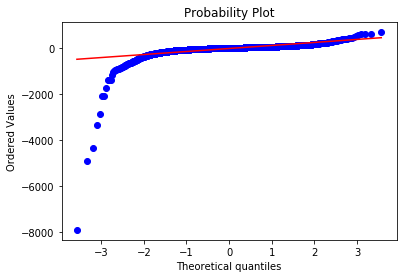

In [28]:
# qq plot for the train residuals
stats.probplot(data_vals[2]['y_pred'] - data_vals[2]['y_real'], dist="norm", plot=pylab)
pylab.show()

## Ridge & Lasso Regression
### Ridge Regression with Untransformed Response

In [29]:
reg_params = 10.**np.linspace(-10, 5, 10)
RidgeCV_model = model_iterations(5, x, y, RidgeCV(alphas=reg_params, fit_intercept=True, cv=5))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Mean Train Score: 0.260587042630276
Mean Test Score: 0.256989120906922


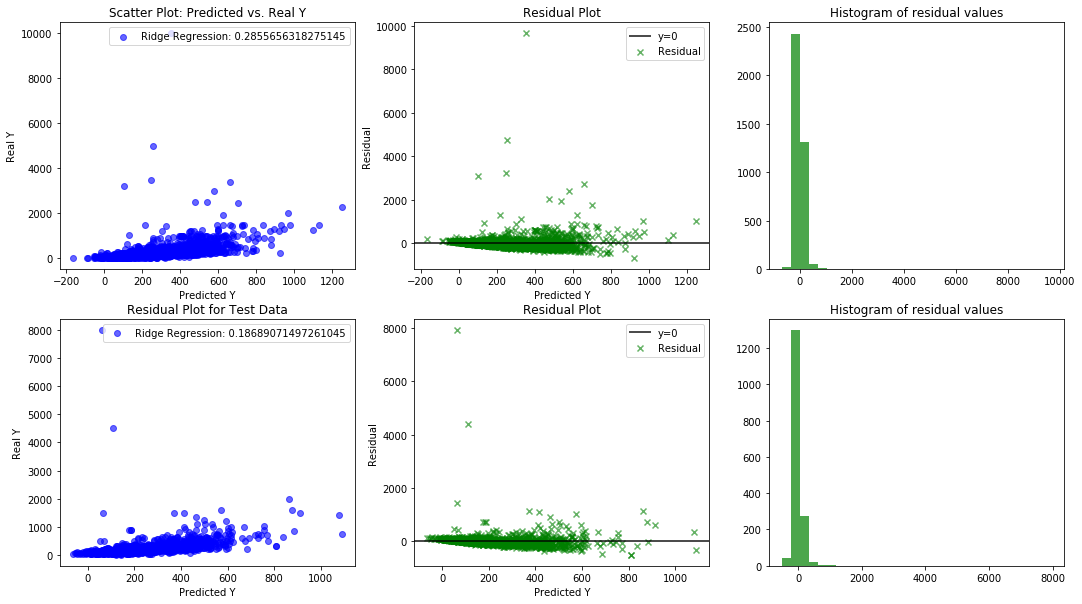

In [30]:
# plot the residuals of a ridge regression model
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

ridge_data_vals = RidgeCV_model.data_frame_convert()
plot_residual(axes[0][0], axes[0][1], axes[0][2], ridge_data_vals[2]['y_pred'], ridge_data_vals[2]['y_real'], 'Ridge Regression: {}'.format(ridge_data_vals[0]), 'Scatter Plot: Predicted vs. Real Y')
plot_residual(axes[1][0], axes[1][1], axes[1][2], ridge_data_vals[3]['y_pred_test'], ridge_data_vals[3]['y_real_test'], 'Ridge Regression: {}'.format(ridge_data_vals[1]), 'Residual Plot for Test Data')
plt.show()

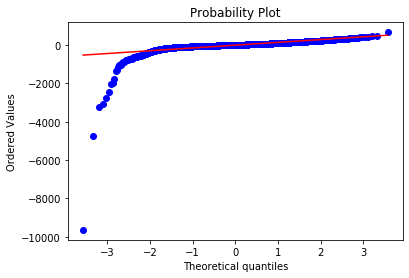

In [31]:
# qq plot for the train residuals
stats.probplot(ridge_data_vals[2]['y_pred'] - ridge_data_vals[2]['y_real'], dist="norm", plot=pylab)
pylab.show()

### Ridge Regression with Log-Transformed Response

In [32]:
reg_params = 10.**np.linspace(-10, 5, 10)
RidgeCV_model = model_iterations(5, x, y_log, RidgeCV(alphas=reg_params, fit_intercept=True, cv=5), True)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The def

Mean Train Score: 0.24862856544674866
Mean Test Score: 0.350442373450933


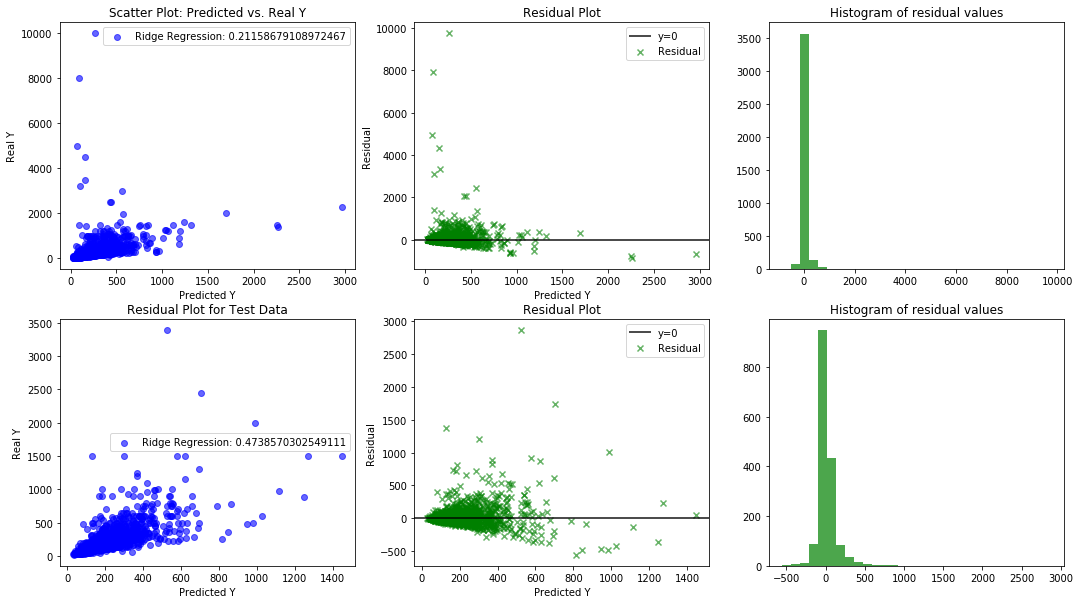

In [33]:
# plot the residuals of a ridge regression model
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

ridge_data_vals = RidgeCV_model.data_frame_convert_log()
plot_residual(axes[0][0], axes[0][1], axes[0][2], ridge_data_vals[2]['y_pred'], ridge_data_vals[2]['y_real'], 'Ridge Regression: {}'.format(ridge_data_vals[0]), 'Scatter Plot: Predicted vs. Real Y')
plot_residual(axes[1][0], axes[1][1], axes[1][2], ridge_data_vals[3]['y_pred_test'], ridge_data_vals[3]['y_real_test'], 'Ridge Regression: {}'.format(ridge_data_vals[1]), 'Residual Plot for Test Data')
plt.show()

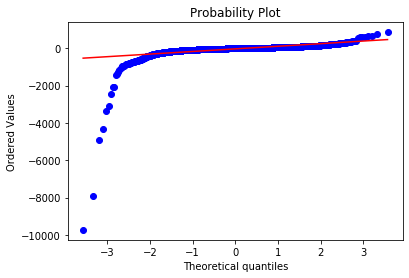

In [34]:
# qq plot for the train residuals
stats.probplot(ridge_data_vals[2]['y_pred'] - ridge_data_vals[2]['y_real'], dist="norm", plot=pylab)
pylab.show()

### Lasso Regression with Untransformed Response

In [35]:
reg_params = 10.**np.linspace(-10, 5, 10)
LassoCV_model = model_iterations(5, x, y, LassoCV(alphas=reg_params, fit_intercept=True, cv=5))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 897975.2294559479, tolerance: 22643.242063370202
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 897589.4262528718, tolerance: 22643.242063370202
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 897577.2213737965, tolerance: 22643.242063370202
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increas

Mean Train Score: 0.28529244131641907
Mean Test Score: 0.23262822032734776


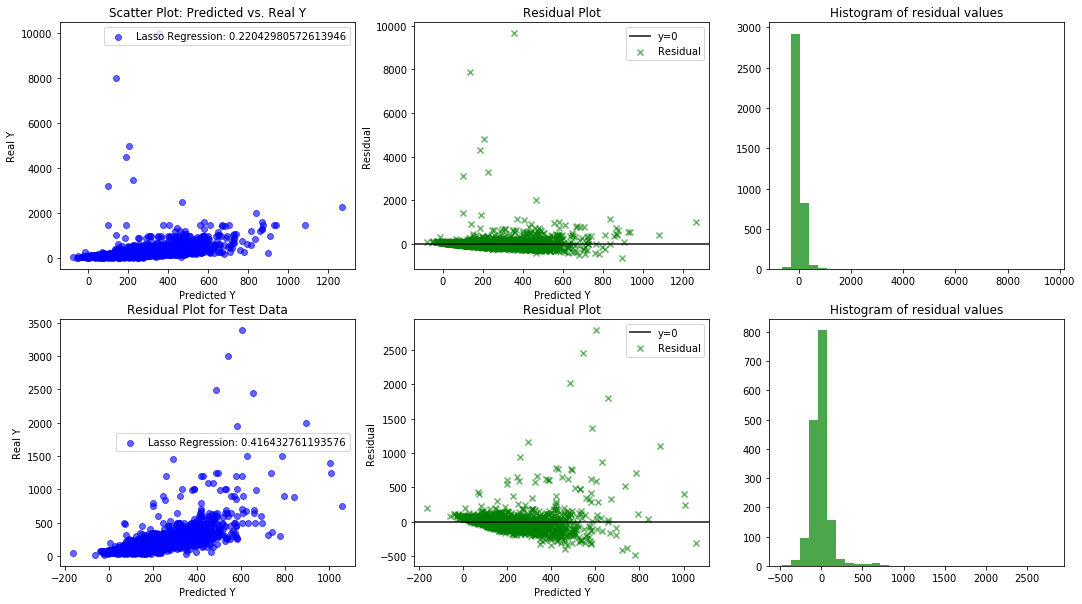

In [36]:
# plot the residuals for a lasso regression model
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

lasso_data_vals = LassoCV_model.data_frame_convert()
plot_residual(axes[0][0], axes[0][1], axes[0][2], lasso_data_vals[2]['y_pred'], lasso_data_vals[2]['y_real'], 'Lasso Regression: {}'.format(lasso_data_vals[0]), 'Scatter Plot: Predicted vs. Real Y')
plot_residual(axes[1][0], axes[1][1], axes[1][2], lasso_data_vals[3]['y_pred_test'], lasso_data_vals[3]['y_real_test'], 'Lasso Regression: {}'.format(lasso_data_vals[1]), 'Residual Plot for Test Data')
plt.show()

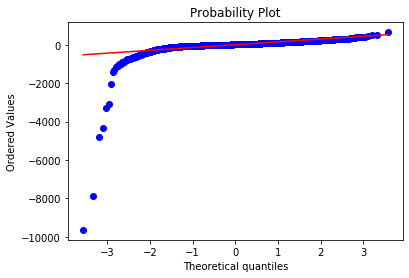

In [37]:
# qq plot for the train residuals
stats.probplot(lasso_data_vals[2]['y_pred'] - lasso_data_vals[2]['y_real'], dist="norm", plot=pylab)
pylab.show()

### Lasso Regression with Log-Transformed Response

In [38]:
reg_params = 10.**np.linspace(-10, 5, 10)
LassoCV_model = model_iterations(5, x, y_log, LassoCV(alphas=reg_params, fit_intercept=True, cv=5), True)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.30215264852825, tolerance: 0.15593899858872592
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.14512190425802, tolerance: 0.15593899858872592
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.141675727652625, tolerance: 0.15593899858872592
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to inc

Mean Train Score: 0.26469493375891384
Mean Test Score: 0.31884873160897287


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.875322620216366, tolerance: 0.15195258519878063
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.875292265526866, tolerance: 0.15195258519878063
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.24989133423298426, tolerance: 0.1563691915195332
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to inc

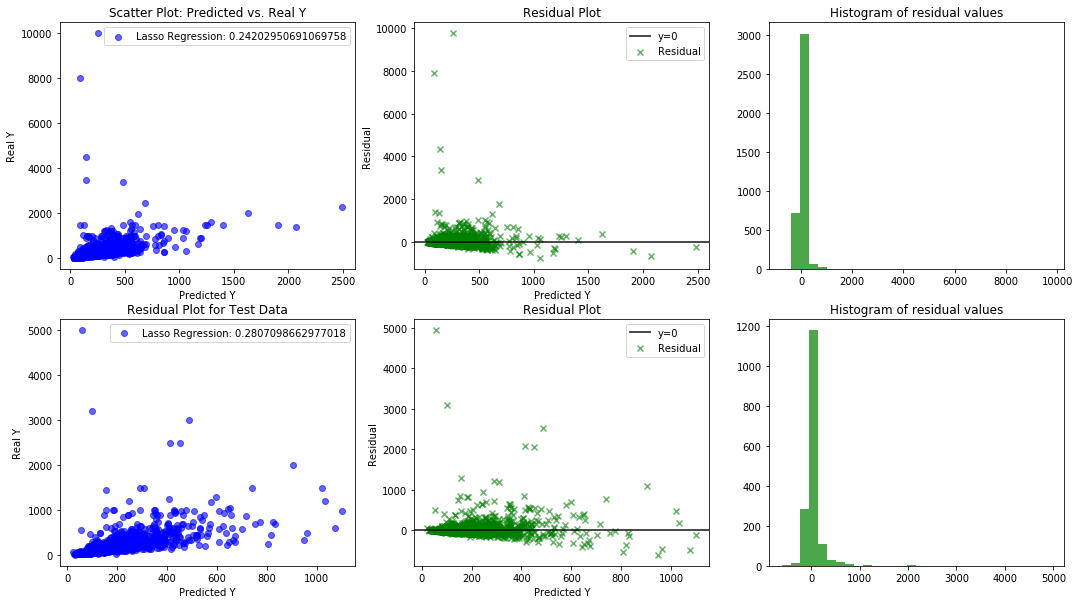

In [39]:
# plot the residuals of a lasso regression model
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

lasso_data_vals = LassoCV_model.data_frame_convert_log()
plot_residual(axes[0][0], axes[0][1], axes[0][2], lasso_data_vals[2]['y_pred'], lasso_data_vals[2]['y_real'], 'Lasso Regression: {}'.format(lasso_data_vals[0]), 'Scatter Plot: Predicted vs. Real Y')
plot_residual(axes[1][0], axes[1][1], axes[1][2], lasso_data_vals[3]['y_pred_test'], lasso_data_vals[3]['y_real_test'], 'Lasso Regression: {}'.format(lasso_data_vals[1]), 'Residual Plot for Test Data')
plt.show()

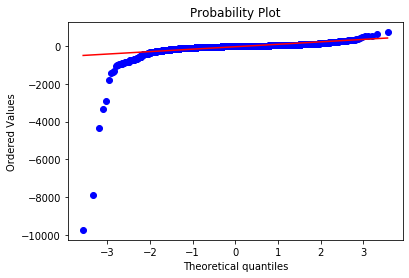

In [40]:
# qq plot for the train residuals
stats.probplot(lasso_data_vals[2]['y_pred'] - lasso_data_vals[2]['y_real'], dist="norm", plot=pylab)
pylab.show()

## Polynomial RidgeCV Model

In [0]:
BIC = lambda n, d, RSS: n * np.log(RSS * 1. / n) + d * np.log(n)
RSS = lambda predict, actual: np.sum((predict - actual)**2)

# Ridge Polynomial Tuning Function
def best_poly_model(pred, response, max_deg, reg_params):
    # track best params
    best_degree = None
    rss_score = None
    
    # tune reg params
    reg_params = 10.**np.linspace(-10, 5, 10)
    
    # tune for degrees
    for degree in range(1, max_deg):
        poly_t = PolynomialFeatures(degree=degree)
        pred_expanded = poly_t.fit_transform(pred)
        ridge = RidgeCV(alphas=reg_params, fit_intercept=True, cv=5)
        ridge.fit(pred_expanded, response)
        response_hat = ridge.predict(pred_expanded)        
        rss_val = RSS(response_hat, response)

        if  rss_val == None:
            rss_score = rss_val
            best_degree = degree

        elif rss_score == None:
            rss_score = rss_val
            best_degree = degree

        elif rss_val > rss_score:
            rss_score = rss_val
            best_degree = degree
            
    return best_degree

def poly_ridge(x, y, degree, log_bool=None):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.90)
    poly_t = PolynomialFeatures(degree=degree)
    pred_expanded = poly_t.fit_transform(x_train)
    pred_test_expanded = poly_t.fit_transform(x_test)
    
    reg_params = 10.**np.linspace(-10, 5, 10)
    ridge = RidgeCV(alphas=reg_params, fit_intercept=True, cv=5)
    ridge.fit(pred_expanded, y_train)
    
    if not log_bool:
        train_score = ridge.score(pred_expanded, y_train)
        test_score = ridge.score(pred_test_expanded, y_test)
    if log_bool:
        train_score = metrics.r2_score(np.exp(pred_expanded), np.exp(y_train))
        test_score = metrics.r2_score(np.exp(pred_test_expanded), np.exp(y_test))
    
    return train_score, test_score

In [42]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.90)
best_degree = best_poly_model(x_train, y_train, 3, reg_params)    
print ('Best Degree:', best_degree)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.09866e-16): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.91868e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.55479e-17): result may not be accurate.
  overwrite_a=False)


Best Degree: 1


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [43]:
print ('Best Degree:', best_degree)

Best Degree: 1


In [44]:
# fit a polynomial with degree 2
scores = poly_ridge(x, y, 2)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.17866e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.0942e-16): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.43084e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [45]:
print ('Train Score for Polynomial RidgeCV:', scores[0] )
print ('Test Score for Polynomial RidgeCV:', scores[1] )

Train Score for Polynomial RidgeCV: 0.25082648527362716
Test Score for Polynomial RidgeCV: 0.21438666370138926


## Median Absolute Error


We now analyze these models by their Median Absolute Error. Intuitively, Median Absolute Error is less sensitive to outliers than Mean Squared Error and translates nicely to a dollar amount that is relative to price.

In [0]:
def median_absolute_errors(x, y, log_bool=None):
    reg_params = 10.**np.linspace(-10, 5, 10)
    models = [ linear_model.Ridge(), RidgeCV(alphas=reg_params, cv=5), linear_model.Lasso(), LassoCV(alphas=reg_params, cv=5), linear_model.ElasticNet(), linear_model.BayesianRidge(), linear_model.OrthogonalMatchingPursuit() ]
    model_labels = np.array(['Ridge', 'RidgeCV', 'Lasso', 'LassoCV', 'ElasticNet', 'BayesRidge', 'OMP'])
    model_errors = np.array([])

    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.35, random_state=15)

    for model in models:
        model.fit(X_train, y_train)
        if not log_bool:
            model_err = metrics.median_absolute_error((y_test), model.predict(X_test))
            model_errors = np.append(model_errors, model_err)
        else:
            model_err = metrics.median_absolute_error(np.exp(y_test), np.exp(model.predict(X_test)))
            model_errors = np.append(model_errors, model_err)
    
    model_position = np.arange(model_errors.shape[0])
    models_sorted = np.argsort(model_errors)
    for i, model in enumerate(model_labels):
        print ('Model {} Results: {}'.format(model_labels[i], model_errors[i]))

    plt.figure(figsize=(10,8))
    plt.bar(model_position, model_errors[models_sorted], align='center')
    plt.xticks(model_position, model_labels[models_sorted])
    plt.xlabel('Estimator')
    plt.ylabel('Median Absolute Error')
    plt.show()

### Median Absolute Error Untransformed Response

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35098799.787027806, tolerance: 31784.13313566924
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57474822.73555094, tolerance: 31784.13313566924
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57412449.39110854, tolerance: 31784.13313566924
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase 

Model Ridge Results: 54.45010386920984
Model RidgeCV Results: 53.639603224851285
Model Lasso Results: 53.726048918229736
Model LassoCV Results: 54.8724214173817
Model ElasticNet Results: 58.21567669431225
Model BayesRidge Results: 53.411854587833744
Model OMP Results: 60.318810498922176


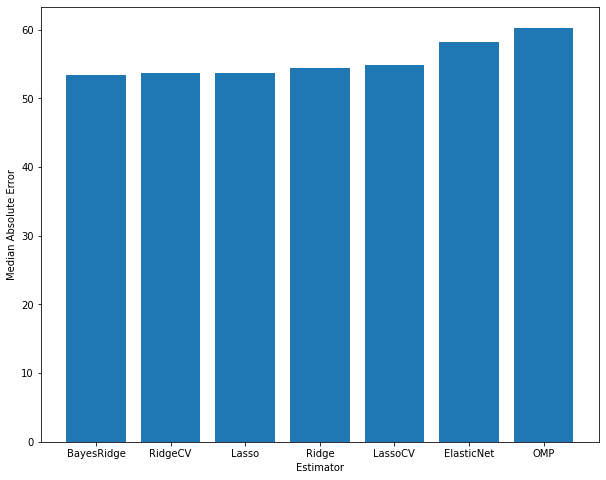

In [47]:
median_absolute_errors(x, y)

### Median Absolute Error Log-Transformed Response

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.039701493578605, tolerance: 0.14870429539711888
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.622959247588483, tolerance: 0.14870429539711888
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.62183760618359, tolerance: 0.14870429539711888
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to incre

Model Ridge Results: 36.09399619453256
Model RidgeCV Results: 36.09399619453256
Model Lasso Results: 69.81610667922422
Model LassoCV Results: 36.80861756850303
Model ElasticNet Results: 69.81610667922422
Model BayesRidge Results: 36.03547733925082
Model OMP Results: 39.69507631688355


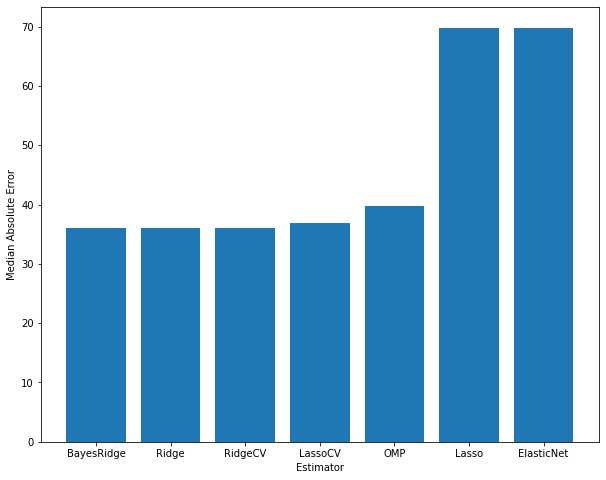

In [48]:
median_absolute_errors(x, y_log, True)

## Predictor Coefficient Matrix

We now look at the coefficient matrix.

In [49]:
reg_params = 10.**np.linspace(-10, 5, 10)
lr = linear_model.RidgeCV(alphas=reg_params)
X_train, X_test, y_train, y_test = train_test_split(x, y_log, test_size=0.35, random_state=15)
lr.fit(X_train, y_train)
# print lr.coef_.argsort()[-20:][::-1]
check = data.drop(['id', 'price_log', 'price', 'host_id'], axis=1)
print (check[lr.coef_.argsort()[-80:][::-1]].columns)
print (check[lr.coef_.argsort()[:80]].columns)

KeyError: ignored

## Random Forest Regressor

We next fit an ensemble method, Random Forest Regressor, and compare its results to that of our previous models.

In [0]:
# random forest regressor
def random_forest_model(x_train, y_train, x_test, y_test):
    best_test_score = 0
    best_train_score = 0
    best_depth = 0
    # tune for tree depth from 1 to 20
    for j in range(1, 21):
        rf = RandomForestRegressor(n_estimators=50, max_depth=j, oob_score=True)
        rf.fit(x_train, y_train)
        score_train = rf.score(x_train, y_train)
        score = rf.score(x_test, y_test)
        if score > best_test_score:
            best_test_score = score
            
            best_train_score = score_train
            best_depth = j
    return best_train_score, best_test_score, best_depth

def random_forest_tuned(best_depth, x, y, description, log_bool=None):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.35)
    rf = RandomForestRegressor(n_estimators=50, max_depth=best_depth, oob_score=True)
    rf.fit(x_train, y_train)
    y_pred_test = rf.predict(x_test)
    if not log_bool:
        print ('{}'.format(description), metrics.median_absolute_error(y_pred_test, y_test))
    if log_bool:
        print ('{}'.format(description), metrics.median_absolute_error(np.exp(y_pred_test), np.exp(y_test)))

### Random Forest Regressor Untransformed Response

In [0]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.35)
rf_values = random_forest_model(x_train, y_train, x_test, y_test)

In [54]:
random_forest_tuned(rf_values[2], x, y, 'Median Absolute Error for Untransformed Response:')

Median Absolute Error for Untransformed Response: 39.78288617340105


### Random Forest Regressor Log-Transformed Response

In [0]:
x_train, x_test, y_train, y_test = train_test_split(x, y_log, test_size=0.35)
rf_values = random_forest_model(x_train, y_train, x_test, y_test)

In [56]:
random_forest_tuned(rf_values[2], x, y, 'Median Absolute Error for Log-Transformed Response:')

Median Absolute Error for Log-Transformed Response: 37.38231346122499


### Ridge Regression Single Listing Untransformed Response

## Single Listing House Data

We now try a regresion solely on single listings as this is where the majority of our listing data lies; namely listings that only had a bed of 1.

In [0]:
data_single = data[data['beds'] == min(data['beds'])]

# split into x_1 and y_1 (note that we do not include id and host_id as predictors)
x_1 = data_single.iloc[:, 2:-2]
y_1 = data_single.iloc[:, -2]
y_1_log = data_single.iloc[:, -1]


### Ridge Regression Single Listing Untransformed Response

In [58]:
reg_params = 10.**np.linspace(-10, 5, 10)
RidgeCV_model = model_iterations(5, x_1, y_1, RidgeCV(alphas=reg_params, fit_intercept=True, cv=5))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Mean Train Score: 0.05265508182044809
Mean Test Score: 0.07366986607188171


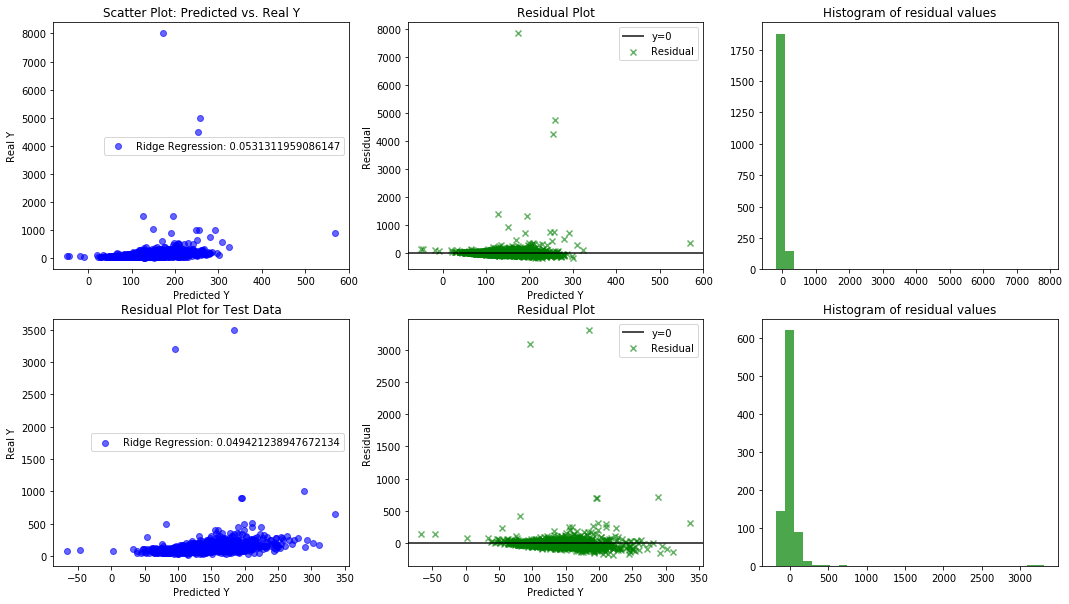

In [59]:
# plot the residuals of a ridge regression model
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

ridge_data_vals = RidgeCV_model.data_frame_convert()
plot_residual(axes[0][0], axes[0][1], axes[0][2], ridge_data_vals[2]['y_pred'], ridge_data_vals[2]['y_real'], 'Ridge Regression: {}'.format(ridge_data_vals[0]), 'Scatter Plot: Predicted vs. Real Y')
plot_residual(axes[1][0], axes[1][1], axes[1][2], ridge_data_vals[3]['y_pred_test'], ridge_data_vals[3]['y_real_test'], 'Ridge Regression: {}'.format(ridge_data_vals[1]), 'Residual Plot for Test Data')
plt.show()

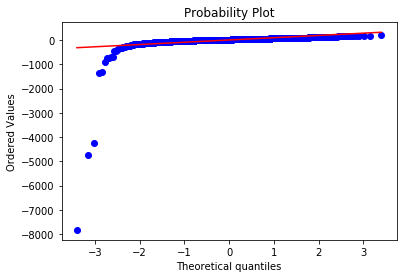

In [60]:
# qq plot for the train residuals
stats.probplot(ridge_data_vals[2]['y_pred'] - ridge_data_vals[2]['y_real'], dist="norm", plot=pylab)
pylab.show()

### Ridge Regression Single Listing Log-Transformed Response

In [61]:
reg_params = 10.**np.linspace(-10, 5, 10)
RidgeCV_model = model_iterations(5, x_1, y_1_log, RidgeCV(alphas=reg_params, fit_intercept=True, cv=5), True)

Mean Train Score: 0.03463854597294484
Mean Test Score: 0.08632514375337519


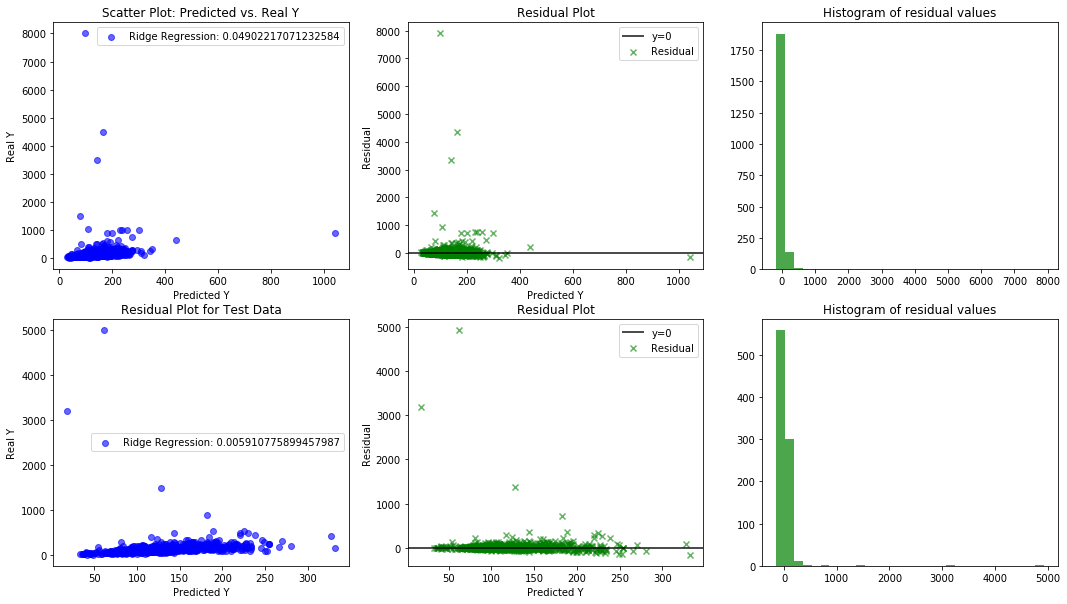

In [62]:
# plot the residuals of a ridge regression model
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

ridge_data_vals = RidgeCV_model.data_frame_convert_log()
plot_residual(axes[0][0], axes[0][1], axes[0][2], ridge_data_vals[2]['y_pred'], ridge_data_vals[2]['y_real'], 'Ridge Regression: {}'.format(ridge_data_vals[0]), 'Scatter Plot: Predicted vs. Real Y')
plot_residual(axes[1][0], axes[1][1], axes[1][2], ridge_data_vals[3]['y_pred_test'], ridge_data_vals[3]['y_real_test'], 'Ridge Regression: {}'.format(ridge_data_vals[1]), 'Residual Plot for Test Data')
plt.show()

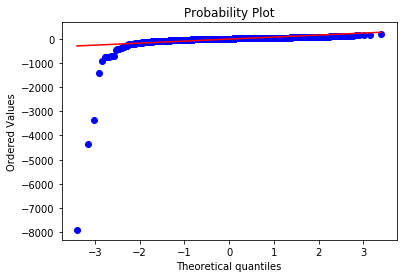

In [63]:
# qq plot for the train residuals
stats.probplot(ridge_data_vals[2]['y_pred'] - ridge_data_vals[2]['y_real'], dist="norm", plot=pylab)
pylab.show()

### Lasso Regression Single Listing Untransformed Response

In [64]:
reg_params = 10.**np.linspace(-10, 5, 10)
LassoCV_model = model_iterations(5, x_1, y_1, LassoCV(alphas=reg_params, fit_intercept=True, cv=5))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2633160.772405658, tolerance: 5085.495230901286
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2632731.0533132963, tolerance: 5085.495230901286
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2632679.496923033, tolerance: 5085.495230901286
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase 

Mean Train Score: 0.07379094530028148
Mean Test Score: 0.017635017897513296


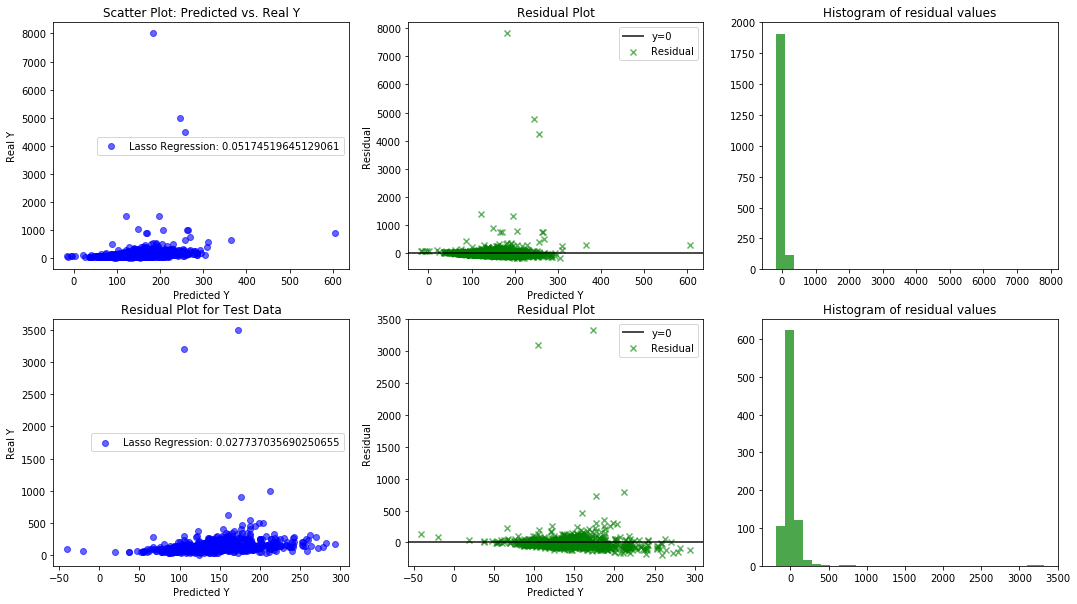

In [65]:
# plot the residuals of a lasso regression model
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

lasso_data_vals = LassoCV_model.data_frame_convert()
plot_residual(axes[0][0], axes[0][1], axes[0][2], lasso_data_vals[2]['y_pred'], lasso_data_vals[2]['y_real'], 'Lasso Regression: {}'.format(lasso_data_vals[0]), 'Scatter Plot: Predicted vs. Real Y')
plot_residual(axes[1][0], axes[1][1], axes[1][2], lasso_data_vals[3]['y_pred_test'], lasso_data_vals[3]['y_real_test'], 'Lasso Regression: {}'.format(lasso_data_vals[1]), 'Residual Plot for Test Data')
plt.show()

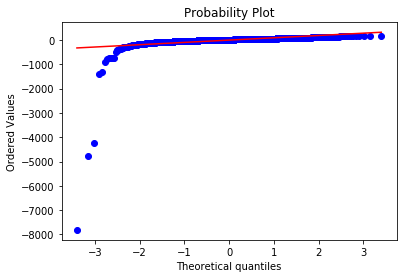

In [66]:
# qq plot for the train residuals
stats.probplot(lasso_data_vals[2]['y_pred'] - lasso_data_vals[2]['y_real'], dist="norm", plot=pylab)
pylab.show()

### Lasso Regression Single Listing Log-Transformed Response

In [67]:
reg_params = 10.**np.linspace(-10, 5, 10)
LassoCV_model = model_iterations(5, x_1, y_1_log, LassoCV(alphas=reg_params, fit_intercept=True, cv=5), True)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.711351825698216, tolerance: 0.05013272672957094
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.881870838252638, tolerance: 0.05013272672957094
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.86051746621837, tolerance: 0.05013272672957094
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to in

Mean Train Score: 0.030762271131491926
Mean Test Score: 0.15007045502026994


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62.185831169536556, tolerance: 0.05158350758089006
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62.18046694179705, tolerance: 0.05158350758089006
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.37152101760784717, tolerance: 0.05014137957859275
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to i

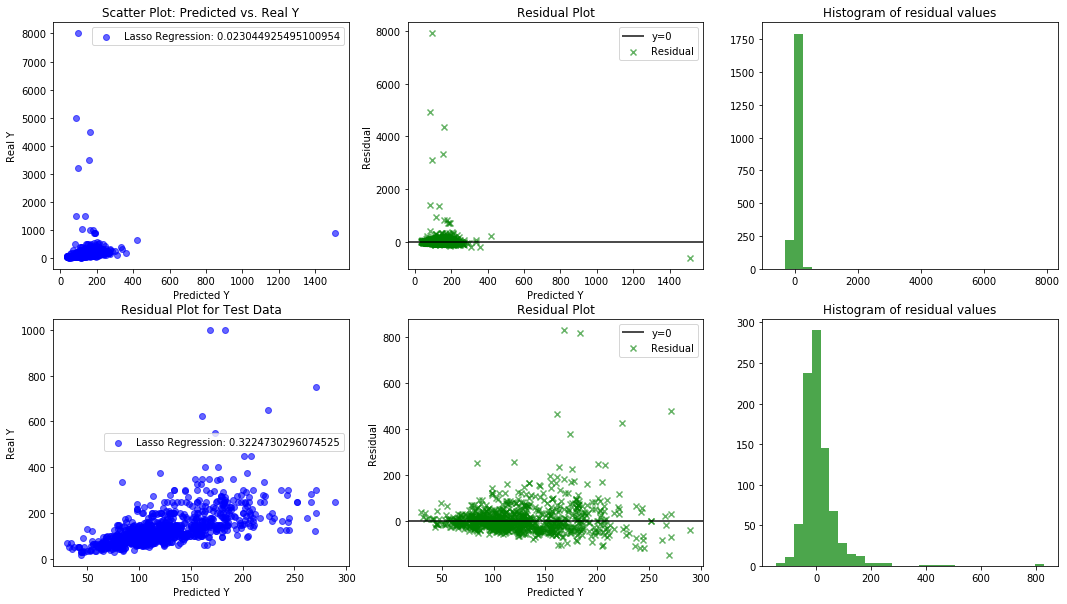

In [68]:
# plot the residuals of a lasso regression model
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

lasso_data_vals = LassoCV_model.data_frame_convert_log()
plot_residual(axes[0][0], axes[0][1], axes[0][2], lasso_data_vals[2]['y_pred'], lasso_data_vals[2]['y_real'], 'Lasso Regression: {}'.format(lasso_data_vals[0]), 'Scatter Plot: Predicted vs. Real Y')
plot_residual(axes[1][0], axes[1][1], axes[1][2], lasso_data_vals[3]['y_pred_test'], lasso_data_vals[3]['y_real_test'], 'Lasso Regression: {}'.format(lasso_data_vals[1]), 'Residual Plot for Test Data')
plt.show()

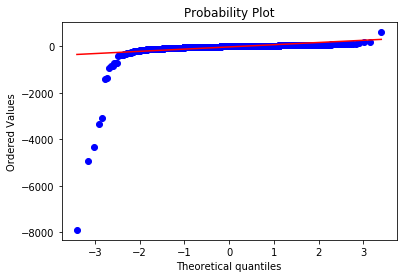

In [69]:
# qq plot for the train residuals
stats.probplot(lasso_data_vals[2]['y_pred'] - lasso_data_vals[2]['y_real'], dist="norm", plot=pylab)
pylab.show()

### Median Absolute Error Single House Listings Untransformed Response

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 955109.2678788155, tolerance: 9870.786630099008
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 954769.1294900924, tolerance: 9870.786630099008
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 954761.8244064897, tolerance: 9870.786630099008
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase t

Model Ridge Results: 34.049811694423234
Model RidgeCV Results: 34.13027364788319
Model Lasso Results: 35.45564429031441
Model LassoCV Results: 35.45564429031441
Model ElasticNet Results: 40.661148500139404
Model BayesRidge Results: 36.495141353818795
Model OMP Results: 36.18441315827645


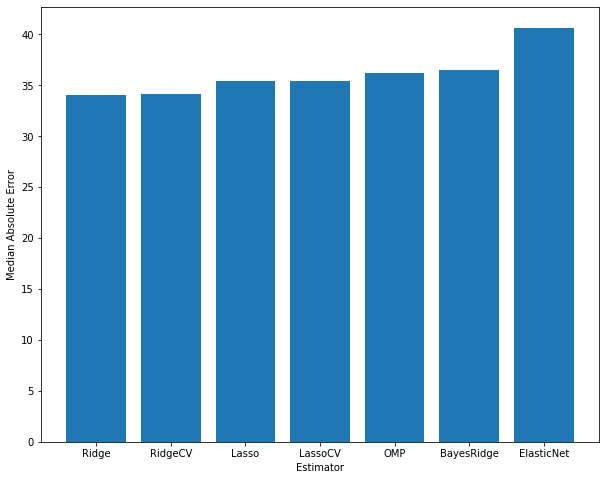

In [70]:
median_absolute_errors(x_1, y_1)

### Median Absolute Error Single House Listings Log-Transformed Response

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.241111297455262, tolerance: 0.04492662767137335
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.929067541214224, tolerance: 0.04492662767137335
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.92143819350794, tolerance: 0.04492662767137335
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to in

Model Ridge Results: 26.851496164669967
Model RidgeCV Results: 26.851496164669967
Model Lasso Results: 37.50000000000003
Model LassoCV Results: 26.240043049899093
Model ElasticNet Results: 37.50000000000003
Model BayesRidge Results: 26.82125369061891
Model OMP Results: 28.59394104944002


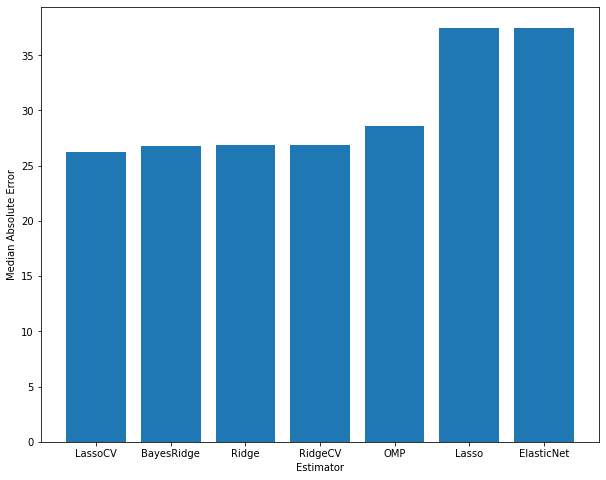

In [71]:
median_absolute_errors(x_1, y_1_log, True)